In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pickle import dump, load

import torch
import torch.nn as nn

In [2]:
# 读取数据, 观察数据格式, 文本内容, 进行数据清洗, 提取特征
def read_data(filename):
    df = pd.read_csv(filename, encoding='utf-8', sep='\t')
    return df

In [3]:
def get_train():
    train_processed = './data/train_processed.csv'
    if os.path.exists(train_processed) and os.path.isfile(train_processed):
        df_train = read_data(train_processed)
    else:
        train_data = './data/train_set.csv'
        df_train = read_data(train_data)
        # 获取每条样本的长度
        df_train.loc[:,'text_len'] = df_train.text.apply(lambda x: len(x.split()))
        df_train.to_csv(train_processed, sep='\t')

    return df_train

In [4]:
df_train = get_train()
test_data = './data/test_a.csv'
df_test = read_data(test_data)

In [5]:
df_train.columns

Index(['Unnamed: 0', 'label', 'text', 'text_len'], dtype='object')

文本数据以被脱敏处理, 无法进行去停用词处理
可进行的处理还有, 高频词处理, 逆文档词处理, 可以通过tf-idf对文本提取特征

In [6]:
# 导入机器学习分类器必须的包
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# 导入f1-score结算器
from sklearn.metrics import f1_score

In [7]:
# 获取机器学习分类器的输入和标签
# sklearn中的特征提取类Countectorizer可以直接使用text列
x = df_train.text.values.tolist()
y = df_train.label.values.tolist()
x_train, x_val, y_train, y_val = train_test_split(x, y, random_state=1234)

57921
2


Text(0.5, 1.0, 'Histogram of char count')

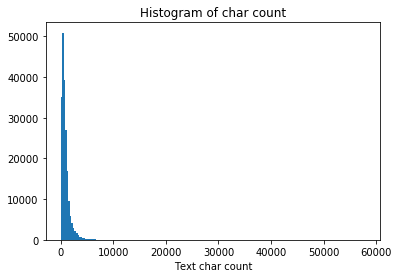

In [8]:
print(df_train.text_len.max())
print(df_train.text_len.min())
_ = plt.hist(df_train['text_len'], bins=200)
plt.xlabel('Text char count')
plt.title("Histogram of char count")

In [9]:
# 基于sklearn定义一个文本分类器,
class text_classifier():
    def __init__(self, classifier=MultinomialNB(),
                vectorizer=TfidfVectorizer(analyzer='word',
                            ngram_range=(1,4),
                            max_features=20000)):
        self.classifier = classifier
        self.vectorizer = vectorizer
    
    def get_features(self, x):
        # x is a list of words string splited by space 
        return self.vectorizer.transform(x)

    def fit(self, x, y):
        self.vectorizer.fit(x)
        self.classifier.fit(self.get_features(x), y)

    def predict(self, x):
        return self.classifier.predict(self.get_features(x))
    
    def score(self, x, y):
        return self.classifier.score(self.get_features(x), y)

    def save_model(self, model_file):
        with open(model_file, 'wb') as f:
            dump((self.classifier, self.vectorizer), f)
    
    def load_model(self, model_file):
        with open(model_file, 'rb') as f:
            self.classifier, self.vectorizer = load(f)

In [10]:
# 使用默认的分类器朴素贝叶斯分类中的multinomialNB()和特征抽取工具
if False:
    classifier_NB = text_classifier()
    model_file = './data/multinomialNB.h5'
    if os.path.exists(model_file) and os.path.isfile(model_file):
        classifier_NB.load_model(model_file)
    else:
        classifier_NB.fit(x_train, y_train)
        classifier_NB.save_model(model_file)
    
    y_predict = classifier_NB.predict(x_val)
    print(f1_score(y_val, y_predict, average='micro'))
    print(f1_score(y_val, y_predict, average='macro'))
    print(f1_score(y_val, y_predict, average='weighted'))

In [16]:
# 使用SVM分类器和特征抽取工具
# 制定kernel类型为linear,且设置根据每个类别的大小设置每一个类别的正则化系数
classifier = SVC(kernel='linear', class_weight='balanced')
vectorizer = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1,3),
    max_features=20000)
classifier_svc = text_classifier(classifier=classifier, vectorizer=vectorizer)
model_svc = './data/svc.h5'
if os.path.exists(model_svc) and os.path.isfile(model_svc):
    classifier_svc.load_model(model_svc)
else:
    classifier_svc.fit(x_train, y_train)
    classifier_svc.save_model(model_svc)

In [17]:
y_predict = classifier_svc.predict(x_val)
print(f1_score(y_val, y_predict, average='micro'))
print(f1_score(y_val, y_predict, average='macro'))
print(f1_score(y_val, y_predict, average='weighted'))

0.93798
0.9252856977172146
0.938384425613409


从本地的测试结果来看SVM分类器的分类效果比朴素贝叶斯的要好上很多.

In [18]:
y_predict = classifier_svc.predict(df_test.text.values.tolist())

In [19]:
submit = pd.Series(data=y_predict, name='label')

In [20]:
submit.to_csv('./data/submit.csv', index=False)

第一次提交SVM在test_a上的分类结果, f1_score是0.0724  
按照类别在样本中的比重,设置正则化项系数C的值,  
C: float, default=1.0  
    Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.  
class_weight: dict or ‘balanced’, default=None  
Set the parameter C of class i to class_weight[i]*C for SVC. If not given, all classes are supposed to have weight one. The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))  
添加class_weight之后,在线测试f1_score为0.926